In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torch.optim.lr_scheduler import StepLR

from sklearn.model_selection import train_test_split

from tqdm import tqdm

import warnings

warnings.filterwarnings("ignore")

plt.style.use('seaborn-whitegrid')

In [2]:
df_train = pd.read_csv('dataset/MNIST_train.csv')

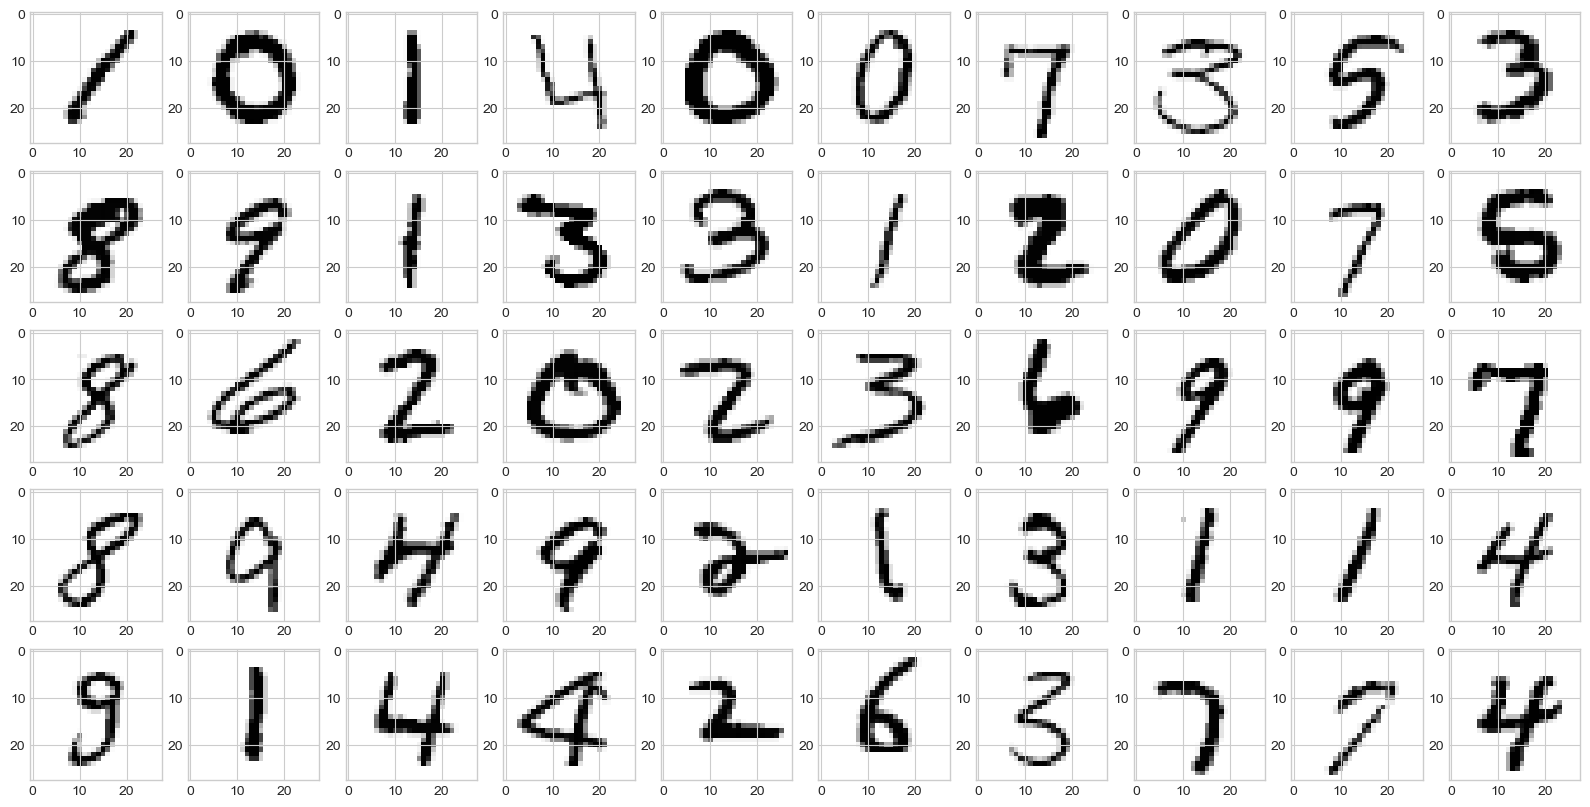

In [5]:
fig, ax = plt.subplots(nrows=5, ncols=10, figsize=(20, 10))

count = 0
for i in range(5):
    for j in range(10):
        data = np.array(df_train.loc[count])
        sample, label = data[1:], data[0]
        count += 1
        ax[i][j].imshow(sample.reshape(28, 28))

In [6]:
fig.savefig('MNIST_draw.jpg', dpi=800, bbox_inches='tight')

In [7]:
class MyDataset(Dataset):
    """构建自己的Dataset对象"""

    def __init__(self, samples, labels):
        self.samples = samples
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        label = self.labels[idx]
        sample = self.samples[idx]
        return sample, label


def interface(name, num, split, batch_size=10):
    """获得训练使用的DataLoader的接口函数"""

    samples, labels = [], []

    df_train = pd.read_csv(name)

    for i in tqdm(range(min(num, len(df_train)))):
        data = np.array(df_train.loc[i])
        samples.append(data[1:].reshape(28, 28))
        labels.append(data[0])

    X = np.array(samples)[:, np.newaxis]
    y = np.array(labels)
    
    # print(X.shape, y.shape)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split)
    
    # print(X_train.shape, X_test.shape)

    return (DataLoader(dataset=MyDataset(samples=X_train,
                                         labels=y_train),
                       batch_size=batch_size, shuffle=True),
            DataLoader(dataset=MyDataset(samples=X_test,
                                         labels=y_test)))

In [8]:
def train_network(net, num_epochs, optimizer, scheduler, criterion,
                  train_loader, test_loader,
                  batch_size, length, test_epochs):
    """训练神经网络所用的函数"""

    # 记录训练信息
    count = 0
    train_loss = np.zeros([num_epochs, 1])
    train_acc = np.zeros([num_epochs, 1])
    test_acc = np.zeros([num_epochs, 1])

    for epoch in range(num_epochs):
        net.train()
        loss_x = 0
        with tqdm(total=length, desc=f'Epoch {epoch + 1}') as pbar:
            for i, train_data in enumerate(train_loader, 1):
                data, labels = train_data
                data = data.double()
                labels = labels.long()
                optimizer.zero_grad()
                predict_label = net(data)
                loss = criterion(predict_label, labels)
                loss_x += loss.item()
                loss.backward()
                optimizer.step()
                count += 1
                pbar.update(1)
            train_loss[epoch] = loss_x / (batch_size * i)

            # 计算并打印训练周期结束后的准确率
            net.eval()
            # 记录训练和验证集中正确和总的个数
            total_correct_train = 0
            total_samples_train = 0
            total_correct_test = 0
            total_samples_test = 0

            with torch.no_grad():
                for batch_data in train_loader:
                    # 取测试数据
                    inputs, label = batch_data
                    inputs = inputs.double()
                    label = label.long()
                    # 前向传播
                    outputs = net(inputs)
                    # 计算准确率
                    _, predicted = torch.max(outputs, 1)
                    total_correct_train += (predicted == label).sum().item()
                    total_samples_train += label.size(0)

                if epoch >= test_epochs:
                    for batch_data in test_loader:
                        # 取测试数据
                        inputs, label = batch_data
                        inputs = inputs.double()
                        label = label.long()
                        # 前向传播
                        outputs = net(inputs)
                        # 计算准确率
                        _, predicted = torch.max(outputs, 1)
                        total_correct_test += (predicted == label).sum().item()
                        total_samples_test += label.size(0)

            # 计算准确率
            acc_train = total_correct_train / total_samples_train
            train_acc[epoch] = acc_train
            if epoch >= test_epochs:
                acc_test = total_correct_test / total_samples_test
                test_acc[epoch] = acc_test

            pbar.set_postfix({'Train count': count,
                              'Loss': train_loss[epoch][0],
                              'Train acc': str(train_acc[epoch][0] * 100)[: 6] + '%',
                              'Test acc': str(test_acc[epoch][0] * 100)[: 6] + '%'})

        # 动态调整学习率
        scheduler.step()

    print("Highest Accuracy:", test_acc.max())
    return train_loss, train_acc, test_acc

In [9]:
class ConvBlock(nn.Module):
    """辅助类"""

    def __init__(self, in_channels, out_channels, maxpool=False):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                      kernel_size=(3, 3), stride=(1, 1), padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

        if maxpool is True:
            self.conv.add_module(name='maxpool',
                                 module=nn.MaxPool2d(2))

    def forward(self, x):
        return self.conv(x)


class ConvNet(nn.Module):
    """用于MNIST手写字体分类的卷积神经网络"""

    def __init__(self):
        super().__init__()

        self.conv = nn.Sequential(
            ConvBlock(in_channels=1, out_channels=32, maxpool=False),
            ConvBlock(in_channels=32, out_channels=64, maxpool=True),
            ConvBlock(in_channels=64, out_channels=128, maxpool=True),
            ConvBlock(in_channels=128, out_channels=256, maxpool=True),
        )

        self.fnn = nn.Sequential(
            nn.Linear(256 * 3 * 3, 128),
            nn.Dropout(p=0.1),
            nn.ReLU(inplace=True),
            nn.Linear(128, 10),
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 256 * 3 * 3)
        return self.fnn(x)

In [20]:
train_num = 1000
batch_size = 10

net = ConvNet().double()

criterion = nn.CrossEntropyLoss(size_average=False)
# optimizer = torch.optim.SGD(net.parameters(), lr=0.008)
optimizer = torch.optim.Adam(net.parameters())
scheduler = StepLR(optimizer, step_size=20, gamma=0.5)

train_loader, test_loader = interface(name='dataset/MNIST_train.csv', num=1000, split=0.5, batch_size=batch_size)

length = int(train_num / batch_size / 2)

train_loss, train_acc, test_acc = train_network(net=net, num_epochs=40, optimizer=optimizer, scheduler=scheduler,
              criterion=criterion, train_loader=train_loader, test_loader=test_loader,
              batch_size=batch_size, length=length, test_epochs=0)

Epoch 40: 100%|██████████| 50/50 [00:07<00:00,  6.40it/s, Train count=2000, Loss=0.000622, Train acc=100.0%, Test acc=97.6%]

Highest Accuracy: 0.978


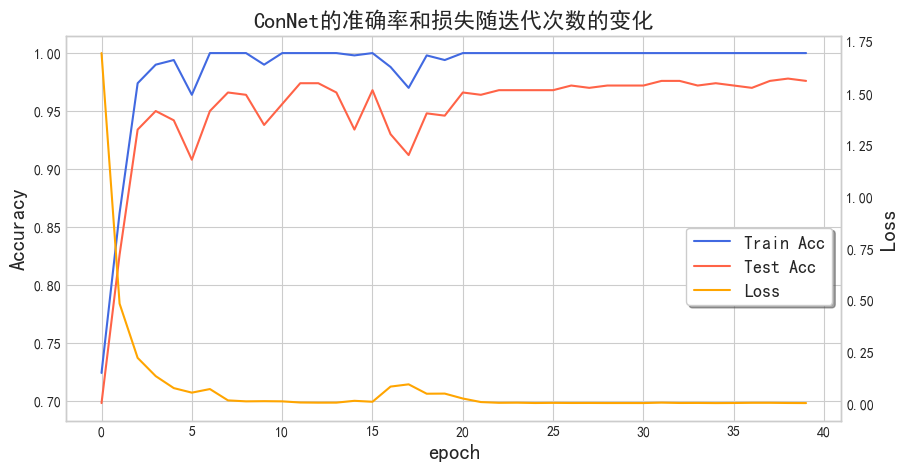

In [21]:
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

fig, ax = plt.subplots(figsize=(10, 5))

ax.set_title('ConNet的准确率和损失随迭代次数的变化', fontsize=16)
ax_ = ax.twinx()

ax.set_xlabel('epoch', fontsize=15)
ax.set_ylabel('Accuracy', fontsize=15)

ax_.set_ylabel('Loss', fontsize=15)

ax.plot(train_acc, color='royalblue', label='Train Acc')
ax.plot(test_acc, color='tomato', label='Test Acc')

ax_.plot(train_loss, color='orange', label='Loss')
ax_.grid(False)

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax_.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc=(0.8, 0.3), fontsize=13,
          frameon=True, shadow=True)

In [22]:
fig.savefig('count.jpg', dpi=800, bbox_inches='tight')

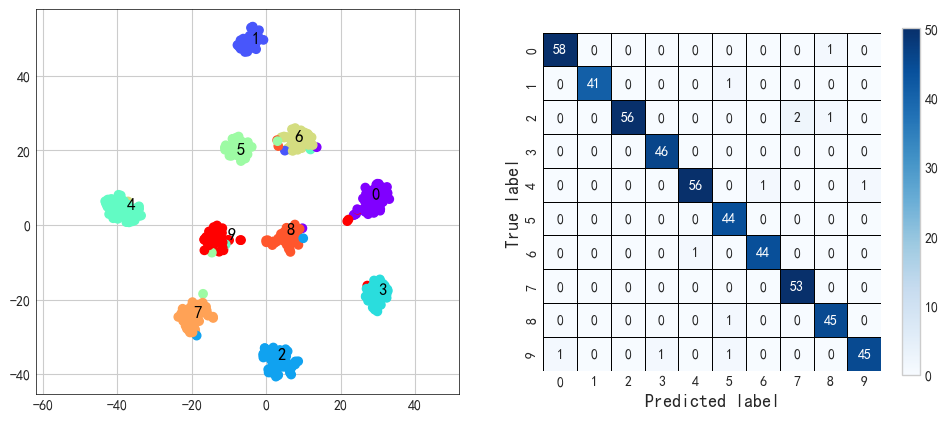

In [23]:
def plot_tSNE_confusion_matrix(net, loader, name='t-SNE+Confusion_matrix.png', save=True, perplexity=20, random_state=42):
    """
    基于Torch Numpy Scikit-learn Seaborn Matplotlib 对神经网络输出的高维数据进行降维可视化，同时绘制t-SNE图与混淆矩阵
    :param net: 已经训练好的神经网络
    :param loader: 用于验证的DataLoader对象
    :param name: 图片保存的名称
    :param save: 是否保存 默认为True
    :param perplexity: t-SNE模型的困惑度
    :param random_state: 使用的随机种子
    :return: None
    """

    from sklearn.manifold import TSNE
    from sklearn.cluster import KMeans
    from sklearn.metrics import confusion_matrix
    from seaborn import heatmap
    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    X = torch.rand(size=(10, 10))
    Y = torch.rand(size=(10,))
    P = torch.rand(size=(10,))

    with torch.no_grad():
        for _, data in enumerate(loader, 1):
            samples, labels = data
            samples = samples.double()
            labels = labels.long()
            outputs = net(samples)
            X = torch.cat([X, outputs])
            Y = torch.cat([Y, labels])
            _, predicted = torch.max(outputs, 1)
            P = torch.cat([P, predicted])

    X = X[10:]
    Y = Y[10:]
    
    P = P[10:]
    
    X_numpy = np.array(X.cpu().numpy())
    Y_numpy = np.array(Y.cpu())
    P_numpy = np.array(P.cpu())
    
    num_data = len(Y_numpy)
    num_classes = len(np.unique(Y_numpy))
    
    X_embedded = TSNE(n_components=2, learning_rate='auto',
                      init='random', perplexity=perplexity, 
                      random_state=random_state).fit_transform(X_numpy)

    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    # fig.subplots_adjust(wspace=0.15)
    
    ax[0].scatter(X_embedded[:, 0], X_embedded[:, 1], c=Y_numpy, cmap='rainbow',
                  # edgecolors='k',
                  # alpha=0.6,
                  # s=90
                  )
    ax[0].axis('equal')
    
    label_list = [{'x': [], 'y': []} for _ in range(num_classes)]
    
    for i in range(0, len(Y)):
        label_list[int(Y_numpy[i])]['x'].append(X_embedded[i][0])
        label_list[int(Y_numpy[i])]['y'].append(X_embedded[i][1])
    
    model = KMeans(n_clusters=1)
    i = 0
    for c_data in label_list:
        x = c_data['x']
        y = c_data['y']
        X = np.array([x, y])
        X = X.T
        model.fit(X)
        center = model.cluster_centers_
        ax[0].text(center[0][0], center[0][1], f"{i}", color='k', fontsize=12)
        i += 1
    
    mat = confusion_matrix(P_numpy, Y_numpy)
    confusion = heatmap(mat.T, square=True, annot=True, fmt='d', cmap='Blues', cbar=False,
                      center=int(num_data / num_classes / 2), vmax=int(num_data / num_classes), ax=ax[1], vmin=0, linecolor='k', linewidths=0.4)
    
    ax[1].set_xlabel('Predicted label', fontsize=13)
    ax[1].set_ylabel('True label', fontsize=13)
    
    for spine in ax[0].spines.values():
        spine.set_edgecolor("black")
        spine.set_linewidth(0.5)
    
    cbar = confusion.figure.colorbar(confusion.collections[0], ax=confusion, location="right",
                               shrink=0.9)
    
    if save is True:
        fig.savefig(name, dpi=1000, bbox_inches='tight')
        
plot_tSNE_confusion_matrix(net=net, loader=test_loader)